# 1. Natural Language Processing
Natural Language Processing step to analyze the comments left on e-commerce orders. The goal is to use this as input to a sentimental analysis model for understanding the customer's sentiment on purchasing things online. Let's take a look on the reviews data.


In [29]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import joblib
from joblib import dump
#language processing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
from sklearn.pipeline import Pipeline

#Classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

#data cleaning
import re
import emoji
import string
from underthesea import word_tokenize
%matplotlib inline


In [30]:
DATA_PATH = "../data_set/ecommerce_review/data.csv"

In [31]:
df_review = pd.read_csv(DATA_PATH)

## 1.1 Data Understanding

In [4]:
df_review.describe()

,star
count,31460.000000
mean,3.736840
std,1.382483
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [5]:
df_review.iloc[659]

content    Sản phẩm không đáng tiền
label                           NEG
star                              1
Name: 659, dtype: object

So we have 31k reviews with label as "POS" for positive and "NEG" for negative. And star column represents the score user give for product.
Let's see the distribution of label and star.

([<matplotlib.patches.Wedge at 0x158f3dc90>,
 [Text(0.8649525640341393, 0.6796006636038316, 'NEG'),
  Text(-0.25107186570127626, 1.0709635466500624, 'NEU'),
  Text(-0.46423848577836774, -0.9972374984537076, 'POS')],
 [Text(0.47179230765498503, 0.3706912710566354, '21.20%'),
  Text(-0.13694829038251433, 0.5841619345363976, '14.93%'),
  Text(-0.253220992242746, -0.543947726429295, '63.87%')])

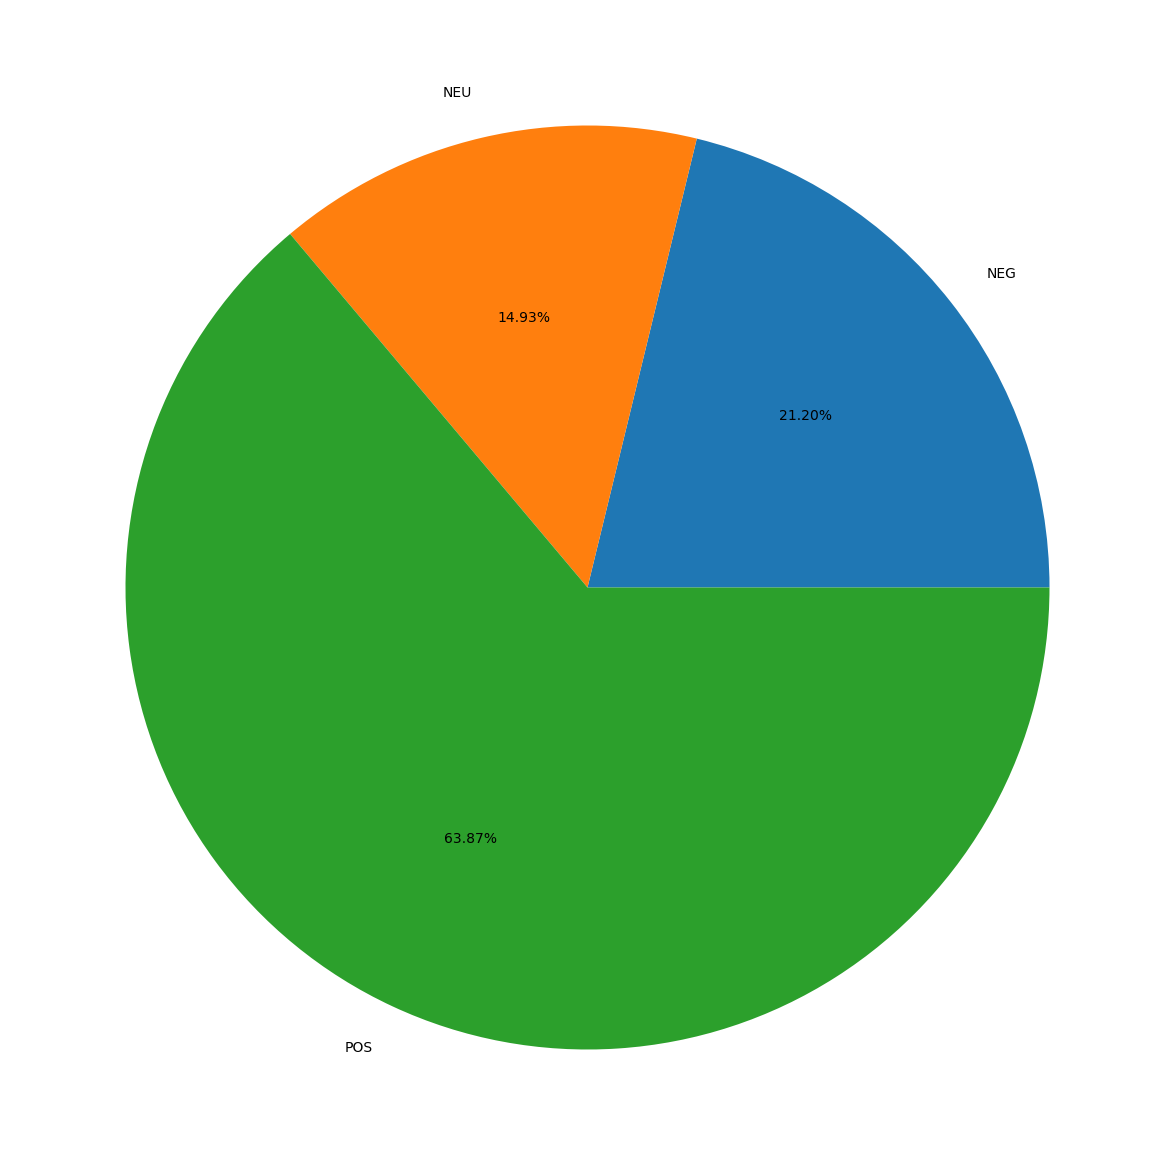

In [17]:
data_label = df_review['label']
data_label = pd.DataFrame(data_label, columns=['label']).groupby('label').size()
plt.figure(figsize=(15, 15))
plt.pie(data_label, autopct="%.2f%%", labels=data_label.index)


The data can be used for building sentimental analysis model. However, before that, we have to do some text preparation to transform the comments input into a vectors which can be used for machine learning modeling.

## 1.2 Data Cleaning using regex (regular expression)

### 1.2.1 clean breakline, hyperlink, date, number, etc...

In [4]:
'''
 For removing breakline
'''
def re_breakline(texts):
    return [re.sub('[\n\r]', ' ',t) for t in texts ]

In [5]:
'''
 For removing punctuation, and space.
'''
def re_punctuation(texts):
    return  [" ".join(re.sub(f"[{re.escape(string.punctuation)}]", " ", str(t).lower()).split()) for t in texts]

In [6]:
'''
 For removing number.
'''
def re_numbers(texts):
    """
    Args:
    ----------
    texts: text content to be prepared [type: string]
    """
    # Applying regex
    return [re.sub('[0-9]+', '', str(t)) for t in texts]

In [7]:
def re_hiperlinks(texts):
    """
    Args:
    ----------
    texts: text content to be prepared [type: string]
    """
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', t) for t in texts]

In [8]:
def re_emoiji(texts):
    """
    Args:
    ----------
    text: list object with text content to be prepared [type: string]
    """
    # Applying regex
    return [emoji.replace_emoji(t) for t in texts]

In [9]:
def re_whitespaces(texts):
    """
    Args:
    ----------
    text:  text content to be prepared [type: string]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', t) for t in texts]
    white_spaces_end = [re.sub('[ \t]+$', '', w) for w in white_spaces]
    return white_spaces_end

### 1.2.2 Stopwords removal

In [10]:
STOP_WORDS_PATH = "../data_set/ecommerce_review/vietnamese-stopwords.txt"
stop_words = []
with open(STOP_WORDS_PATH, 'r') as file:
    for line in file:
        line = line.strip()
        if line:  # Skip empty lines
            stop_words.append(line)  # Add the line's element to the list

In [11]:
def data_tokenizer(texts, stop_words = stop_words):
    return [' '.join([c for c in word_tokenize(t.lower()) if c not in stop_words]) for t in texts]

In [32]:
def process(texts):
    texts = re_numbers(texts)
    texts = re_breakline(texts)
    texts = re_punctuation(texts)
    texts = re_hiperlinks(texts)
    texts = re_whitespaces(texts)
    texts = re_emoiji(texts)
    texts = data_tokenizer(texts)
    return texts


In [33]:
df_review['cleaned_comment'] = process(df_review['content'])
df_review['cleaned_comment']

0                                               áo bao đẹp
1                                                tuyệt vời
2                                       day ao khong giong
3                               mùi thơm bôi lên da mềm da
4                                          vải đẹp dày dặn
                               ...                        
31455                                      không đáng tiền
31456                                             quần đẹp
31457                                    hàng đẹp giá tiền
31458                                          chất vải ổn
31459    áo ok vải mịn len cổ phối form mùa đông chất m ng
Name: cleaned_comment, Length: 31460, dtype: object

## 1.3 Feature extraction

After the comments are cleaned by above process, we would like to give more meaning for the text we are analysing, we can use approachs like Bag of Words, TF-IDF and Word2Vec. For our analysis easier, let's define a function that receives a text and a vectorizer object and applies the feature extraction on the respective text

We create train set, test set by using scikit-learn.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df_review['cleaned_comment'], df_review['label'], test_size = .15, shuffle = True, stratify=df_review['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, shuffle = True, stratify=y_train)

In [64]:
vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, use_idf=True)

In [67]:
X_train = vectorizer.fit_transform(X_train).toarray()
X_valid = vectorizer.transform(X_valid).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [68]:
print(X_train.shape, X_valid.shape, X_test.shape)

(21392, 4313) (5349, 4313) (4719, 4313)


In [41]:
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 1.4 Model trainning and performance evaluation

Let create a utility function to support plotting confusion matrix

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setti ng `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


First, let's use randomforest to train the model

In [69]:
%time
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs


RandomForestClassifier(n_estimators=1000, random_state=0)

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
cfs_matrix = confusion_matrix(y_test,y_pred)
print(cfs_matrix)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 713   68  219]
 [ 216  104  385]
 [ 119   81 2814]]
              precision    recall  f1-score   support

         NEG       0.68      0.71      0.70      1000
         NEU       0.41      0.15      0.22       705
         POS       0.82      0.93      0.88      3014

    accuracy                           0.77      4719
   macro avg       0.64      0.60      0.60      4719
weighted avg       0.73      0.77      0.74      4719

0.7694426785335876


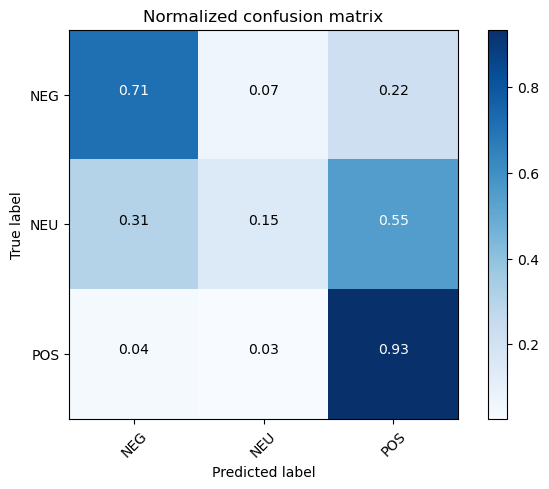

In [46]:
class_names = ['NEG', 'NEU', 'POS']
plt.figure()
plot_confusion_matrix(cfs_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Next, let's try out with Naive Bayes classifier

In [70]:
PIPELINES_PATH = '../pipelines'
MODELS_PATH = '../models'

# Saving pkl files
dump(vectorizer, os.path.join(PIPELINES_PATH, 'vectorizer.pkl'))
dump(classifier, os.path.join(MODELS_PATH, 'final_model.pkl'))

['../models/final_model.pkl']

In [47]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

preds = nb.predict(X_test)

In [48]:
cfs_nb = confusion_matrix(y_test,preds)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))
print(accuracy_score(y_test, preds))

[[ 588   30  382]
 [ 198   47  460]
 [ 130   46 2838]]
              precision    recall  f1-score   support

         NEG       0.64      0.59      0.61      1000
         NEU       0.38      0.07      0.11       705
         POS       0.77      0.94      0.85      3014

    accuracy                           0.74      4719
   macro avg       0.60      0.53      0.53      4719
weighted avg       0.69      0.74      0.69      4719

0.7359610086882814


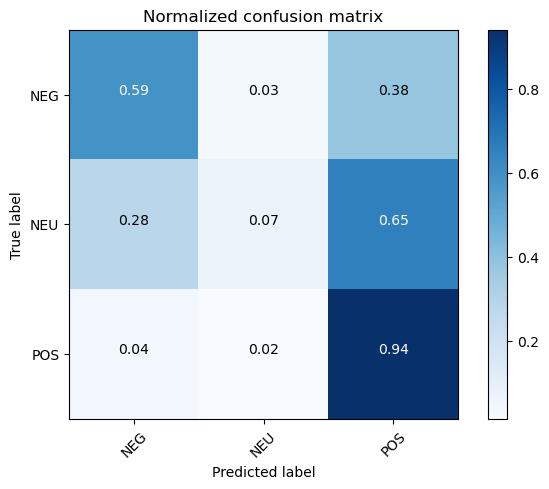

In [49]:
plt.figure()
plot_confusion_matrix(cfs_nb, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

## 2. Pipeline

After defining and testing all the above steps. We'll create a pipeline to apply a complete pipeline automatically to handle text preprocessing and processing. This is a very important steps on the projects because we can apply all processes for text handling for preparing and training.

First, we create a utility function to support our model. 

In [22]:
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize sentiment [type: model]
    """

    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)

    # Predicting sentiment
    pred = model.predict(matrix)

    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 'POS':
        text = 'Positive'
        color = 'seagreen'
    elif pred[0] == 'NEG':
        text = 'Negative'
        color = 'crimson'
    else:
        text = 'Neutral'
        color = 'gray'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

In [12]:
class ApplyRegex(BaseEstimator, TransformerMixin):

    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)

        return X

In [13]:
class TextFeatureExtraction(BaseEstimator, TransformerMixin):

    def __init__(self, vectorizer, train=True):
        self.vectorizer = vectorizer
        self.train = train

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.train:
            return self.vectorizer.fit_transform(X).toarray()
        else:
            return self.vectorizer.transform(X).toarray()

In [16]:
text_transformers = {
    'numbers': re_numbers,
    'emoiji': re_emoiji,
    'breakline': re_breakline,
    'punctuation': re_punctuation,
    'hiperlinks': re_hiperlinks,
    'whitespaces': re_whitespaces,
    'tokenizer': data_tokenizer
}

# Building the Pipeline
train_text_pipeline = Pipeline([
    ('processing_text', ApplyRegex(text_transformers)),
    ('vectorizer', TextFeatureExtraction(vectorizer))
])
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_review['content'], df_review['label'], test_size = .15, shuffle = True, stratify=df_review['label'])
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train_2, y_train_2, test_size = .2, shuffle = True, stratify=y_train_2)

Model training pipeline is created as below

In [17]:
trainning_pipeline = Pipeline([
    ('text_prep', train_text_pipeline),
    ('random_forest', RandomForestClassifier(n_estimators=1000, random_state=0))
])

Let's try out our pipeline

In [57]:
trained_model = trainning_pipeline.fit(X_train_2, y_train_2)
trained_model.shape

AttributeError: 'Pipeline' object has no attribute 'shape'

In [58]:
X_train_2.shape

(21392,)

In [ ]:
vectorized_text_pipeline = Pipeline([
    ('processing_text', ApplyRegex(text_transformers)),
    ('vectorizer', TextFeatureExtraction(vectorizer = vectorizer, train=False))
])
transformed_x_test = vectorized_text_pipeline.transform(['san pham tot', 'san pham ok'])
transformed_x_test.shape

In [ ]:
dump(vectorizer = vectorizer, train=False), os.path.join(PIPELINES_PATH, 'vectorizer.pkl'))

In [ ]:
X_test_2

In [ ]:
trained_model.named_steps

In [ ]:
y_pred = trained_model.named_steps['random_forest'].predict(transformed_x_test)

In [ ]:
y_pred

In [ ]:
final_model = trained_model.named_steps['random_forest']

Finally, we save our model and it's now ready for deploying into production

['../models/final_model.pkl']